# Clasificador de figuras 3D

Este documento tiene la finalidad de comprender a detalle un ejemplo de un análisis topológico de datos (TDA por sus siglas en inglés) presentado en la página de [Giotto-tda](https://giotto-ai.github.io/gtda-docs/latest/notebooks/classifying_shapes.html). En dicho documento se examina como `giotto-tda` extrae características topológicas de una nube de datos, las cuales se aprovechan en un clasificador de figuras 3D.

## Generación de datos
Como primer paso se generan datos sintéticos con los cuales podemos comenzar a trabajar, para lo cual utilizamos la función `make_point_clouds` del módulo `generate_datasets`, el cual fue obtenido en la página oficial del [GitHub](https://github.com/giotto-ai/giotto-tda/blob/master/examples/data/generate_datasets.py) del mismo ejemplo. En este caso generaremos datos provenientes de 10 $S^1$, $S^2$ y $T^1$ con ruido agregado.

La función `make_point_clouds` toma los siguientes argumentos:
* `n_samples_per_shape`: Un número de tipo `int` que indica cuántas muestras deseamos obtener.
* `n_points`: Un número de tipo `int` que indica el tamaño de cada muestra.
* `noise`: Un número de tipo `float` entre 0 y 1 que indica la cantidad de ruido aleatorio presente en cada muestra.

y regresa la tupla `(point_clouds, labels)`, donde
* `point_clouds` es, a su vez, una tupla `(circle_point_clouds, sphere_point_clouds, torus_poin_clouds)` donde
    * `circle_point_clouds` es un arreglo que representa la muesta aleatoria de $S^1$.
    * `sphere_point_clouds` es un arreglo que representa la muestra aleatoria de $S^2$.
    * `torus_point_clouds` es un arreglo que representa la muestra aleatoria de $T^1$.
* `labels` es, a su vez, una tupla `(circle_labels, sphere_labels, torus_labels)` donde
    * `circle_labels` es un arreglo de ceros
    * `sphere_labels` es un arreglo de unos.
    * `torus_labels` es un arreglo de 2's.

In [1]:
import sys
print(sys.path)
from data.generate_3DFigures import make_point_clouds

# Para este ejemplo consideraremos 10 nubes de datos para cada clase con 10 puntos cada una y un ruido de 0.1
n_samples_per_class = 10
n_points = 10
noise = 0.1

point_clouds, labels = make_point_clouds(n_samples_per_shape=n_samples_per_class, n_points=n_points, noise=noise)
print(point_clouds.shape)

print(f'Se generaron {point_clouds.shape[0]} nubes de puntos en {point_clouds.shape[1]} dimensiones, '
     f'cada una con {point_clouds.shape[2]} puntos.')

['C:\\Users\\Acer\\TDA-practice', 'C:\\Users\\Acer\\miniconda3\\python310.zip', 'C:\\Users\\Acer\\miniconda3\\DLLs', 'C:\\Users\\Acer\\miniconda3\\lib', 'C:\\Users\\Acer\\miniconda3', '', 'C:\\Users\\Acer\\miniconda3\\lib\\site-packages', 'c:\\users\\acer\\delfín-tda\\peptidemodels', 'C:\\Users\\Acer\\miniconda3\\lib\\site-packages\\win32', 'C:\\Users\\Acer\\miniconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Acer\\miniconda3\\lib\\site-packages\\Pythonwin']
(30, 100, 3)
Se generaron 30 nubes de puntos en 100 dimensiones, cada una con 3 puntos.


Para comprender mejor el resultado graficamos una nube de puntos aleatoria de cada variedad ($S^1, S^2, T^1$) utilizando la función `plot_point_cloud` del módulo `plotting`. Esta función (al igual que todas las que de este módulo) regresa un objeto de tipo `plotly.figure_object.Figure`.

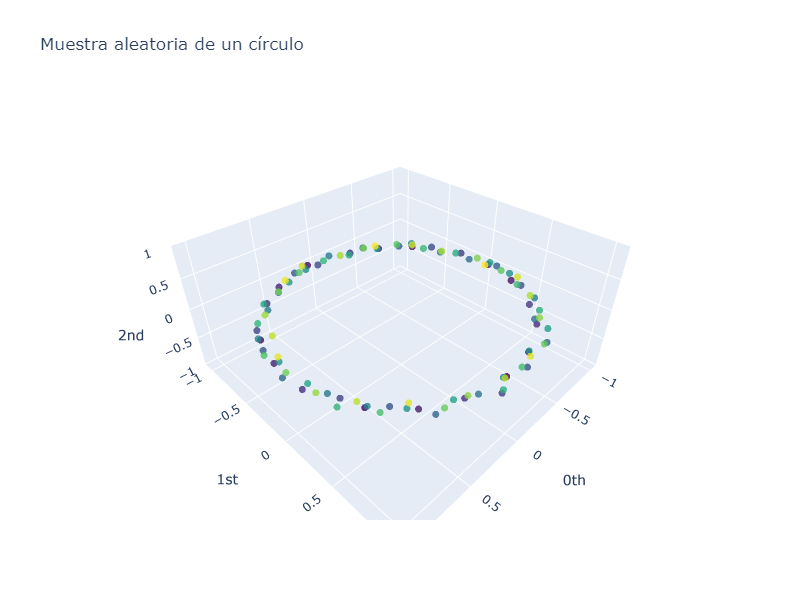

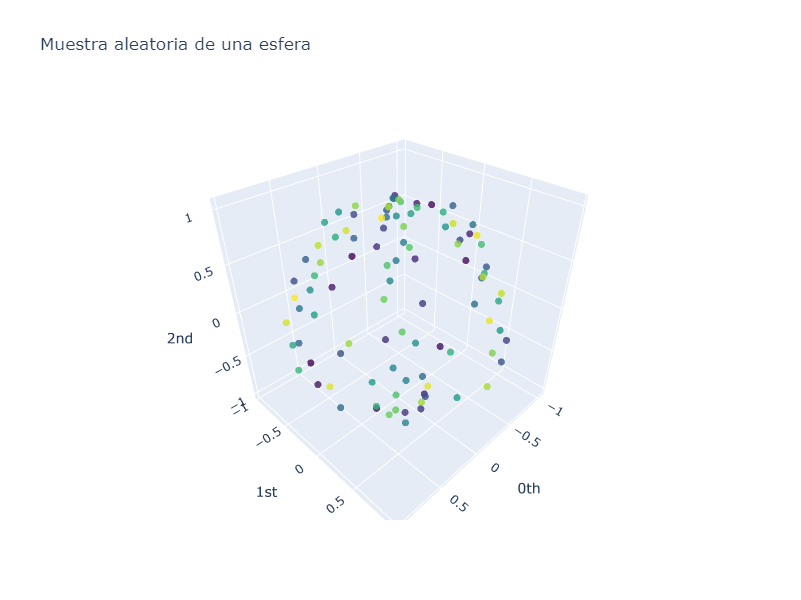

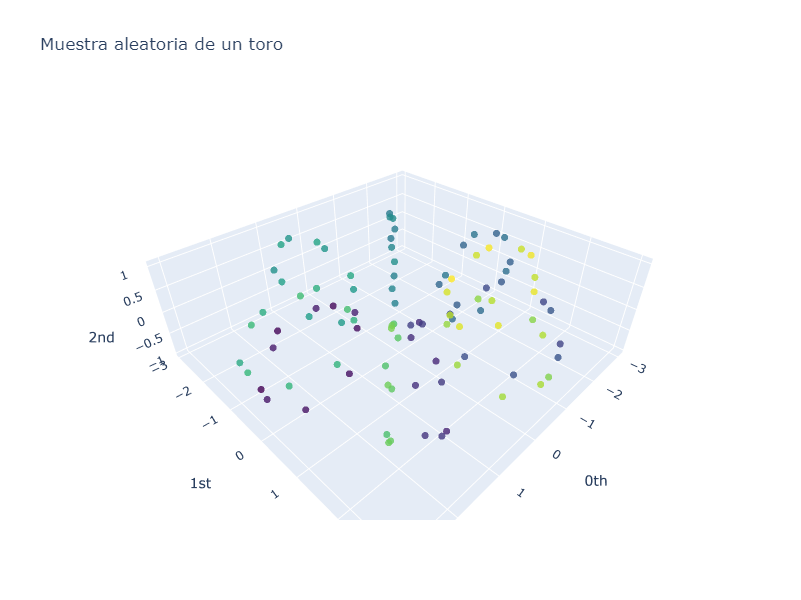

In [3]:
from gtda.plotting import plot_point_cloud
from random import randint

random_circle = randint(0, 9)
random_sphere = randint(10, 19)
random_torus = randint(20, 29)

circle_plot = plot_point_cloud(point_clouds[random_circle], 
                               plotly_params={'layout':{'title':'Muestra aleatoria de un círculo',
                                                       'width':800, 'height':600}})
sphere_plot = plot_point_cloud(point_clouds[random_sphere], 
                               plotly_params={'layout':{'title':'Muestra aleatoria de una esfera',
                                                       'width':800, 'height':600}})
torus_plot = plot_point_cloud(point_clouds[random_torus], 
                               plotly_params={'layout':{'title':'Muestra aleatoria de un toro',
                                                       'width':800, 'height':600}})

circle_plot.show()
sphere_plot.show()
torus_plot.show()

## Cálculo de la homología persistente

Una vez que hemos generado los datos, comenzamos el análisis topológico de los mismos calculando su homología persistente mediante la función `VietorisRipsPersistence` del módulo `gtda.homology`. Dicha función calcula la homología persistente de una nube de puntos utilizando complejos de Vietoris-Rips.

La función `VietorisRipsPersistence` (al igual que todos las funciones de homología persistente en `gtda.homology`) reciben como entrada arreglos 3D (en algunos casos listas de arreglos 2D). Para cada entrada del arreglo de entrada la función calcula un resumen topológico en forma de un arreglo 2D y los sintetiza en un arreglo 3D. En este caso, cada entrada del arreglo es una nube de puntos de `point_clouds`.

De esta forma, cada elemento `digrams[i]` contiene información sobre la topología de `point_clouds[i]`. La forma de interpretar cada fila de `diagrams[i]` es la siguiente:
* `diagramas[i][0]` representa el "nacimiento" de una característica topológica.
* `diagramas[i][1]` representa la "muerte" de una característica topológica.

Dado que trabajamos con la construcción de Vietoris-Rips, podemos interpretar al parámetro de filtrado como una distancia $\varepsilon$ para el radio de cada $\varepsilon$-vecindad al rededor de cada punto en la respectiva nube de datos. De esta forma, las características topológicas mencionadas hacen referencia a hoyos $d$-dimensionales, cada hoyo representado por un generador en su respectivo grupo de homología $H_d$. Podemos especificar el grupo de homología en el que deseamos trabajar mediante el parámetro `homology_dimensions`, el cual toma como entrada una lista objetos tipo `int`.

Para este ejemplo mantendremos `collapse_edges=False` puesto que en la [documentación](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.VietorisRipsPersistence.html#id5) se recomienda aplicar el algoritmo de [*Edge Collapse*](https://drops.dagstuhl.de/storage/00lipics/lipics-vol164-socg2020/LIPIcs.SoCG.2020.19/LIPIcs.SoCG.2020.19.pdf) en los casos en que el conjunto de datos o la cantidad de dimensiones a considerar son altas.

In [11]:
%%time
from gtda.homology import VietorisRipsPersistence

homology_dimensions = [0, 1, 2]

VR = VietorisRipsPersistence(homology_dimensions=homology_dimensions,
                            metric='euclidean',
                            collapse_edges=False)

diagrams = VR.fit_transform(point_clouds)
diagrams.shape

CPU times: total: 5.69 s
Wall time: 8.04 s


(30, 172, 3)

## Gráficos de Persistencia
Por otra parte, podemos obtener el gráfico de persistencia que representa la información topológica contenida en diagrams mediante la función `plot_diagram` del módulo `plotting`. Dado que las nubes de datos provienen de variedades de dimensión 3, basta con observar los primeros 3 gupos de homología. idealmente se espera que
* En $S^1$ se observe:
  * 1 punto de $H_0$ alejado de la diagonal.
  * 1 punto de $H_1$ alejado de la diagonal.
  * 0 puntos de $H_2$ alejados de la diagonal.
* En $S^2$ se observe:
  * 1 punto de $H_0$ alejado de la diagonal.
  * 0 puntos de $H_1$ alejados de la diagonal.
  * 1 punto de $H_2$ alejado de la diagonal.
* En $T^1$ se observe:
  * 1 punto de $H_0$ alejado de la diagonal.
  * 2 puntos de $H_1$ alejados de la diagonal.
  * 1 punto de $H_2$ alejado de la diagonal.

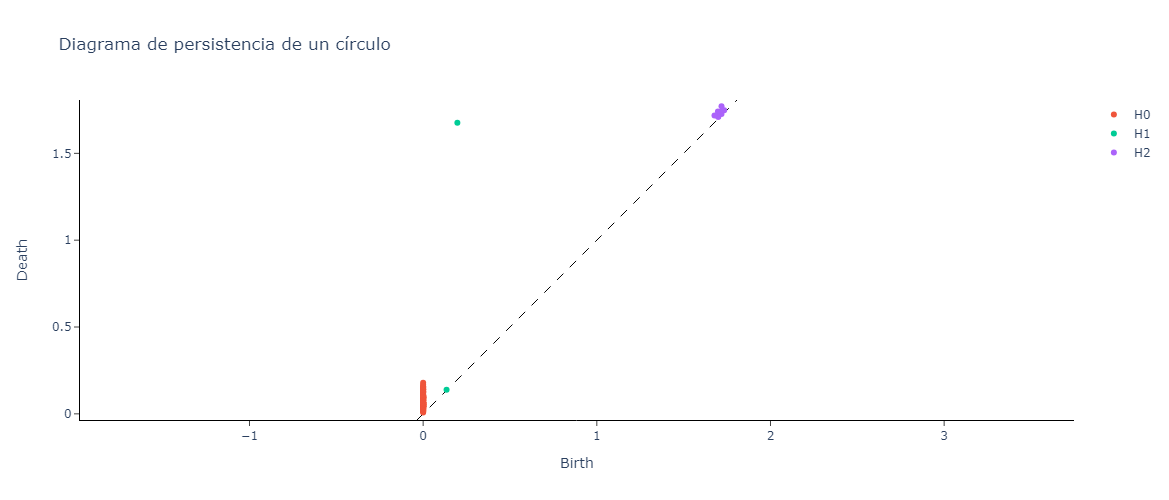

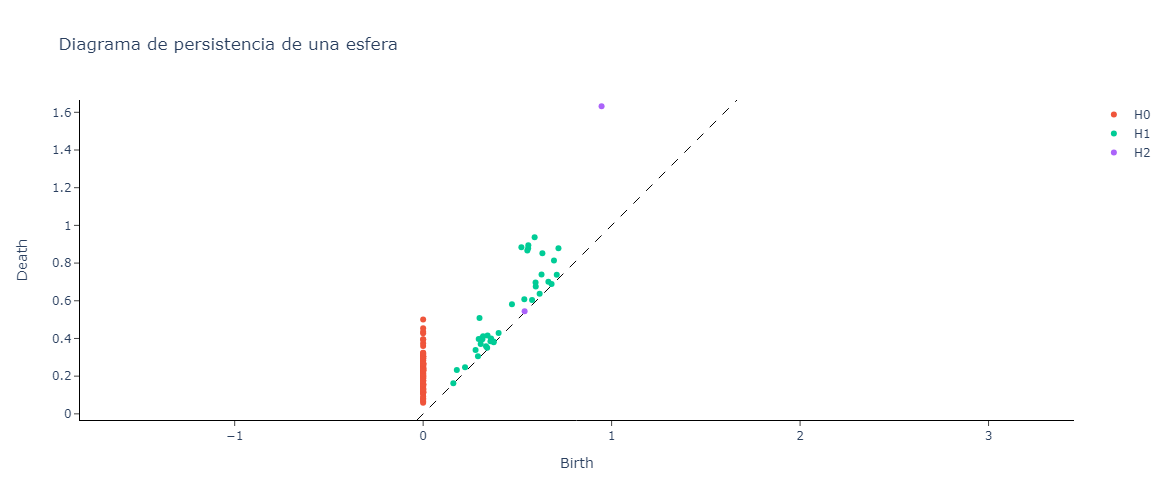

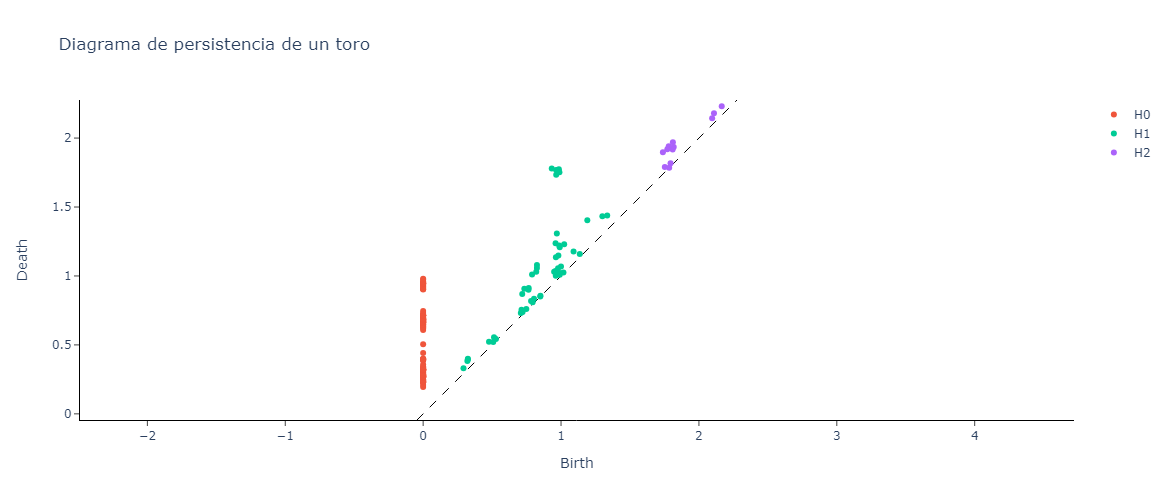

In [13]:
from gtda.plotting import plot_diagram

circle_diagram = plot_diagram(diagrams[random_circle], 
                              plotly_params={'layout':{'title':'Diagrama de persistencia de un círculo'}})
sphere_diagram = plot_diagram(diagrams[random_sphere],
                              plotly_params={'layout':{'title':'Diagrama de persistencia de una esfera'}})
torus_diagram = plot_diagram(diagrams[random_torus],
                              plotly_params={'layout':{'title':'Diagrama de persistencia de un toro'}})

circle_diagram.show()
sphere_diagram.show()
torus_diagram.show()

En los diagramas anteriores podemos observar que existen diferencias con respecto a las suposiciones "ideales", puesto que
* En $S^2$ se observan puntos de $H_1$ ligeramente alejados de la diagonal.
* En $T^1$ se observa un cúmulo de puntos en $H_1$ considerablemente alejados de la diagonal, y ningún punto de $H_2$ notablemente alejado de la diagonal.
  
Lo anterior puede deberse al tamaño de la muestra tomada, como podemos observar en el gráfico de la nube de datos de $T^1$, donde pareciera haber una sucesión de círculos, mas no un toro.

## Considerando una muestra de mayor tamaño
Para observar el contraste con un conjunto de datos de mayor tamaño, generaremos nuevas nubes de puntos, esta vez considerando 30 puntos por muestra y agregando mayor ruido.

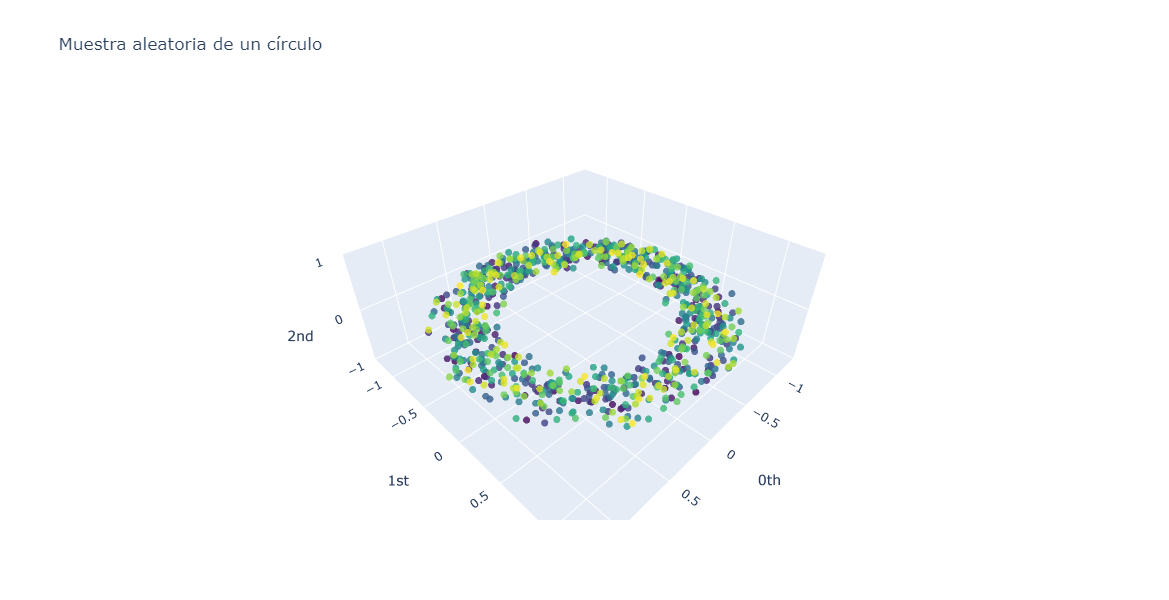

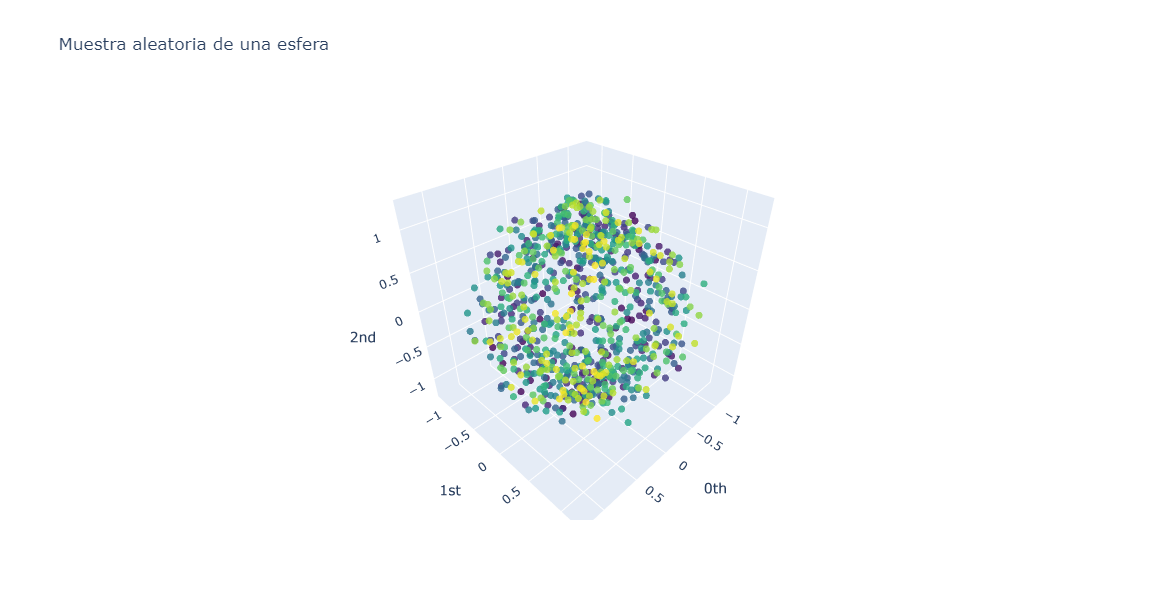

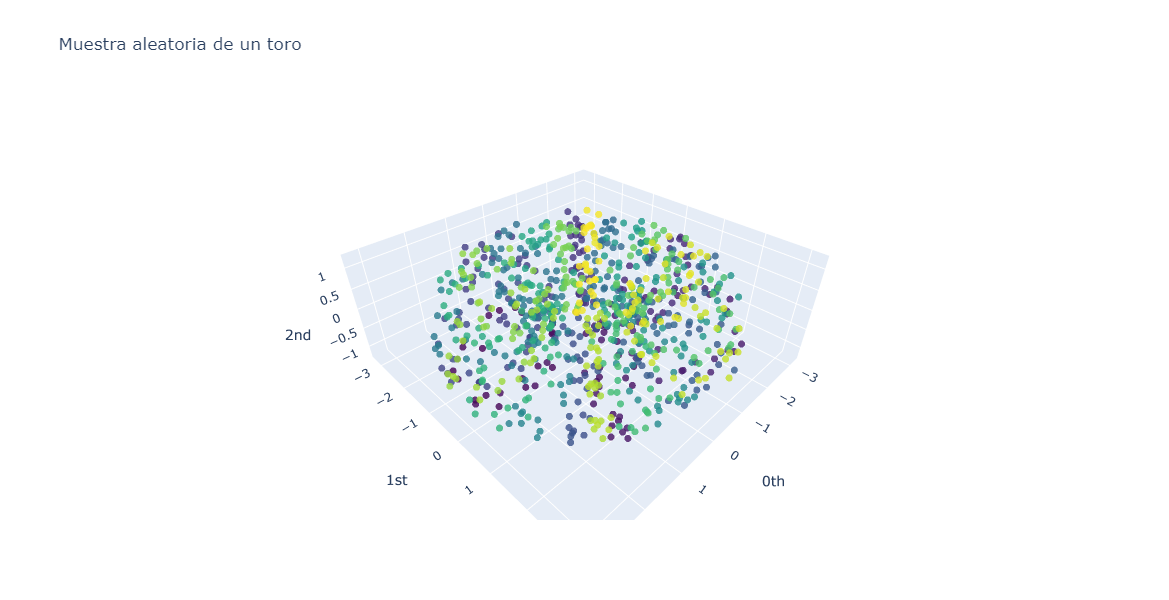

In [16]:
n_points = 30
noise = 0.5

point_clouds_big, labels_big = make_point_clouds(n_samples_per_shape=n_samples_per_class, n_points=n_points, noise=noise)

circle_plot_big = plot_point_cloud(point_clouds_big[random_circle], 
                                   plotly_params={'layout':{'title':'Muestra aleatoria de un círculo',
                                                           'width':800, 'height':600}})
sphere_plot_big = plot_point_cloud(point_clouds_big[random_sphere], 
                                   plotly_params={'layout':{'title':'Muestra aleatoria de una esfera',
                                                            'width':800, 'height':600}})
torus_plot_big = plot_point_cloud(point_clouds_big[random_torus], 
                                   plotly_params={'layout':{'title':'Muestra aleatoria de un toro',
                                                           'width':800, 'height':600}})

circle_plot_big.show()
sphere_plot_big.show()
torus_plot_big.show()

Dado que en esta ocasión la cantidad de datos sí pueden representar un problema para el cálculo de la homología persistente de las distintas figuras, aplicamos `collapse_edges=True` al modelo.

In [18]:
%%time
VR_big = VietorisRipsPersistence(homology_dimensions=homology_dimensions,
                                metric='euclidean',
                                collapse_edges=True)

diagrams_big = VR_big.fit_transform(point_clouds_big)

CPU times: total: 20min 46s
Wall time: 21min 31s


Podemos notar que los diagramas de persistencia de las muestras aleatorias con una mayor cantidad de puntos se apegan más a la homología de las variedades de las cuales provienen a pesar del ruido agregado, esto es de esperarse dado el teorema de Niyogi-Smale-Weinberger.

Notemos que las diferencias en los diagramas son observables pero no considerablemente grandes, mientras que el tiempo de ejecución del código pasó de aproximandamente 3 segundos a aproximadamente 21 minutos.

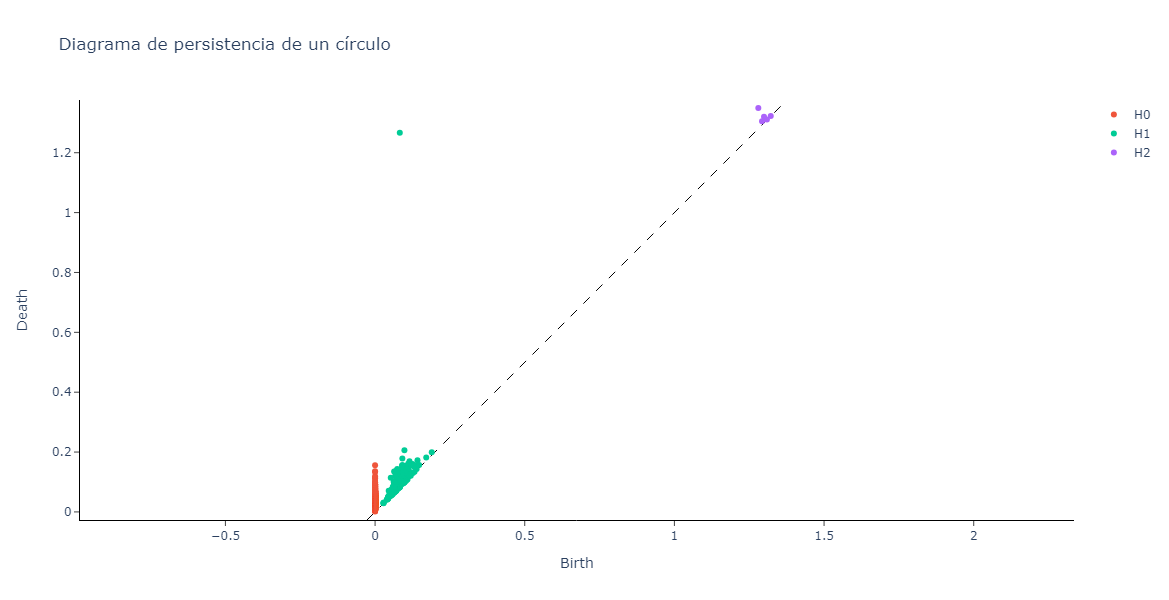

In [184]:
plot_diagram(diagrams_big[random_circle], 
             plotly_params={'layout':{'title':'Diagrama de persistencia de un círculo', 'width':800, 'height':600}})


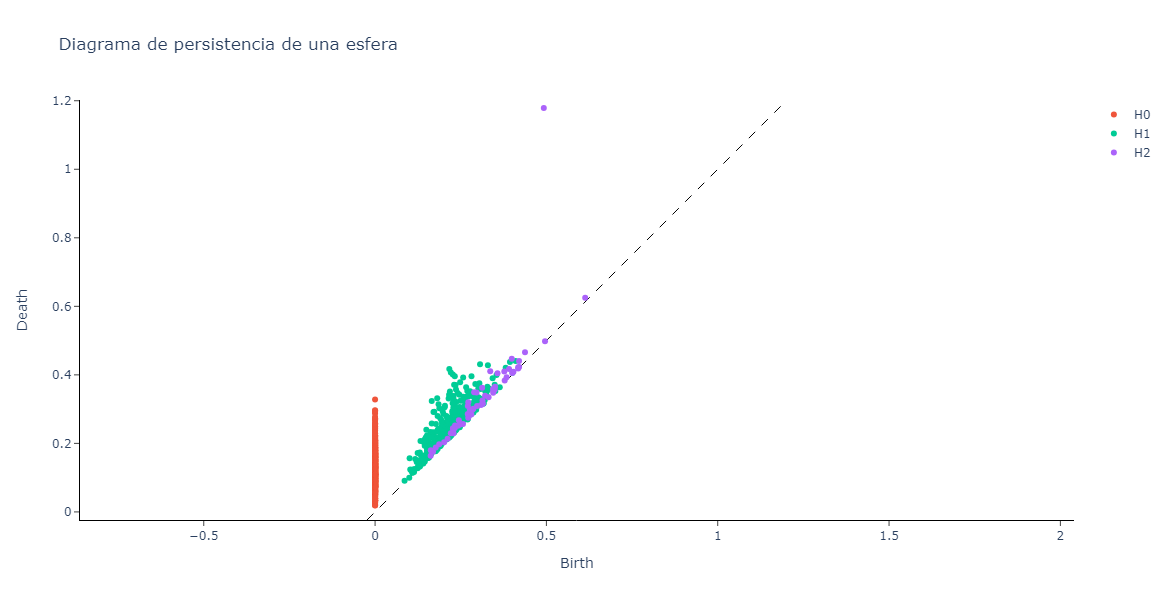

In [186]:
plot_diagram(diagrams_big[random_sphere],
             plotly_params={'layout':{'title':'Diagrama de persistencia de una esfera', 'width':800, 'height':600}})

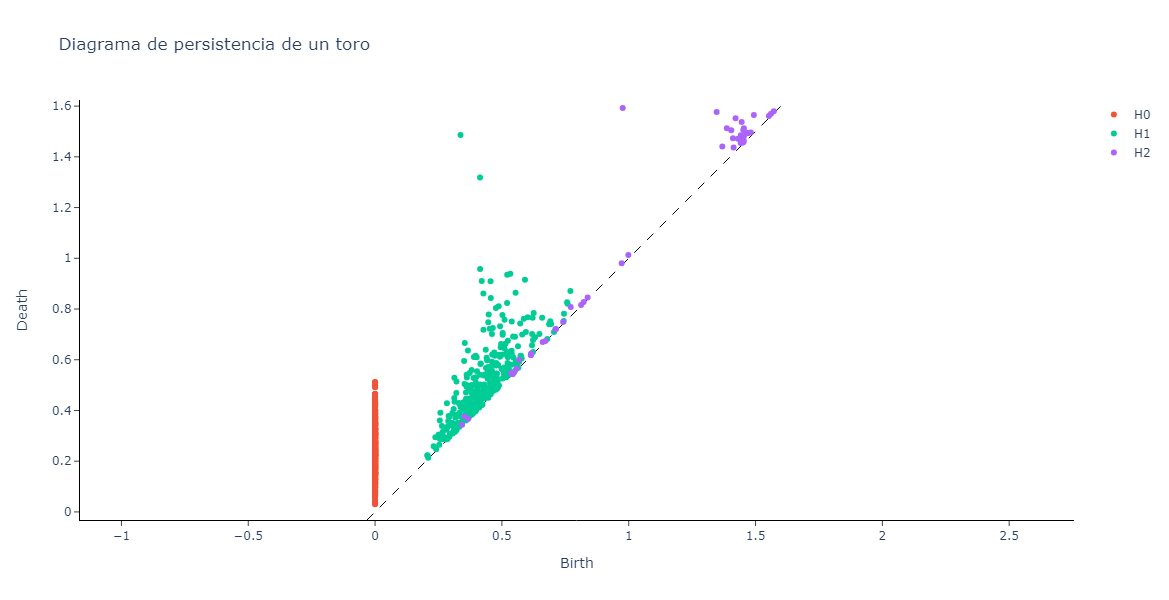

In [188]:
plot_diagram(diagrams_big[random_torus],
             plotly_params={'layout':{'title':'Diagrama de persistencia de un toro', 'width':800, 'height':600}})

A pesar de que los diagramas anteriores son visualmente explicativos, la información contenida en ellos no es fácilmente interpretable por un algoritmo de *machine learning* ni directamente comparable. Para solucionar estas limitaciones, distintas formas de "vectorizar" los diagramas de persistencia han sido propuestas; las disponibles en Giotto-tda se encuentran en el módulo `gtda.diagrams`. El método que abordaremos en este ejemplo se conoce como *Entropía de Persistencia*.

## Entropía de Persistencia
La idea de la entropía de persistencia es medir la "entropía" de un diagrama de persistencia $D=\{(b_i,d_i)\}_{i\in I}$ con $d_i<+\infty$. La entropía de $D$ se define como
$$
E(D)=-\sum_{i\in I}p_i\ln p_i
$$
donde
$$
p_i=\frac{d_i-b_i}{L_D}\qquad\text{y}\qquad L_D=\sum_{i\in I}(d_i-b_i)
$$
El cálculo de la entropía de $D$ puede realizarse mediante la función `PersistenceEntropy` en el módulo `gtda.diagrams`. Al calcular la entropía de los diagrmas previamente calculados, obtenemos una tupla de dimensiones (30, 3), correspondientes a las 30 muestras de distinitas variedades y los 3 números que representan a la entropía de cada diagrama, es decir, cada diagrama de persistencia queda representado por solo 3 números. Cabe resaltar que las dimensiones de la entropía de las muestras pequeñas y las de las muestras grandes son las mismas, pues la dimensión de la entropía no depende de la cantidad de puntos.

In [45]:
from gtda.diagrams import PersistenceEntropy

persistence_entropy = PersistenceEntropy()

diagrams_entropy = persistence_entropy.fit_transform(diagrams)
diagrams_big_entropy = persistence_entropy.fit_transform(diagrams_big)

print(diagrams_entropy.shape)
print(diagrams_big_entropy.shape)

(30, 3)
(30, 3)


Observemos que las dimensiones de la entropía calculada nos permiten visualiar la misma, obteniendo dos gráficas distintas. En ambas gáficas podemos observar tres grandes grupos de puntos, de tal forma que el clasificador no debería tener problemas en separar las distintas clases. Observemos además que la diferencia en las clases son más marcadas en el diagrama correspondiente a la muestra pequeña.

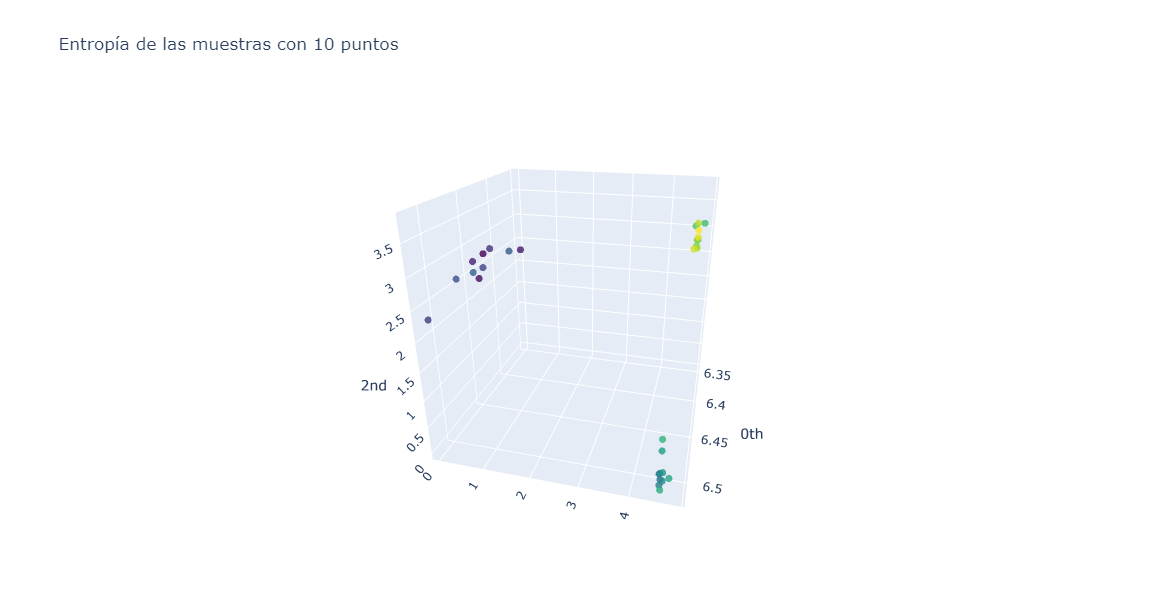

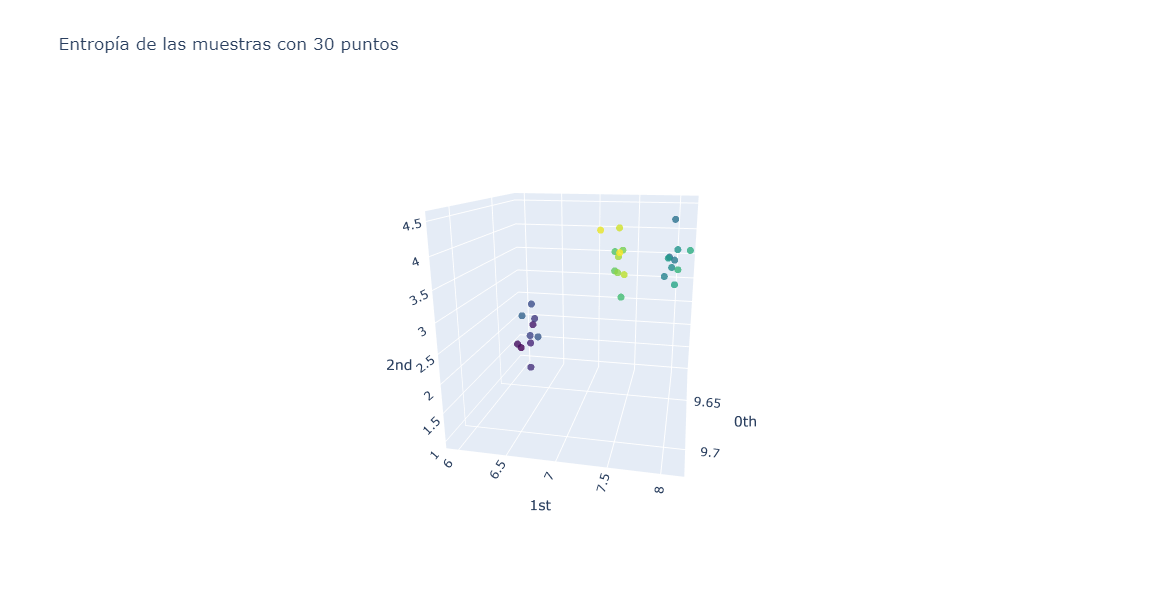

In [57]:
clusters = plot_point_cloud(diagrams_entropy, 
                           plotly_params={'layout':{'title':'Entropía de las muestras con 10 puntos',
                                                   'width':800, 'height':600}})
clusters_big = plot_point_cloud(diagrams_big_entropy,
                               plotly_params={'layout':{'title':'Entropía de las muestras con 30 puntos',
                                                       'width':800, 'height':600}})

clusters.show()
clusters_big.show()

## Entrenamiento del clasificador
Dado que ambos conjutnos de datos son relativamente pequeños, utilizaremos un clasificador Random Forest. Al igual que en el ejemplo de Giotto-tda, utilizaremos un OOB score para evaluar la eficiencia del modelo. Podemos observar que el OOB score obtenido en ambos casos es de 1.00, por lo que en ambos casos el modelo ha separado perfectamente las tres clases. En este ejemplo podemos notar como la carencia de una muestra más grande y la precencua de ruido no parecen tener gran peso en el análisis topológico de datos.

In [65]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True)
rf_big = RandomForestClassifier(oob_score=True)

classifier = rf.fit(diagrams_entropy, labels)
classifier_big = rf.fit(diagrams_big_entropy, labels_big)

print(classifier.oob_score_)
print(classifier_big.oob_score_)

1.0
1.0


## Desarollo de un pipeline
Como se ha observado a lo largo de este documento, hay toda una serie de distintos pasos a realizar para pasar de una nube de datos a un clasificador, es decir, la integración del TDA a un algoritmo de machine learning, aunque posible, no es inmediata. Con la finalidad de automatizar este proceso recurrimos a la clase `Pipeline` del módulo `gtda.pipeline`, la cual nos permite reproducir la serie de pasos mostrada anteriormente. Recapitulando, los pasos esenciales para lograr un clasificador fueron:
* Calcular la homología persistente de nuestra nube de datos mediante `VietorisRipsPersistence`.
* Calcular la entropía de los diagramas mediante `PersistenceEntropy`.
* Ajustar un modelo Random Forest untilizando `RandomForestClassifier`.

Los detalles de cada modelo pueden encontrarse en los correspondientes capítulos de este documento.

In [88]:
from gtda.pipeline import Pipeline

steps = [
    ('persistence', VietorisRipsPersistence(metric='euclidean', homology_dimensions=homology_dimensions)),
    ('entropy', PersistenceEntropy()),
    ('model', RandomForestClassifier(oob_score=True))
]

pipeline = Pipeline(steps)

A partir de este punto, podemos utilizar el método `fit` para entrenar un modelo Random Forest medinate un TDA como el realizado anteriormente en una sola línea de código, y acceder a los distintos modelos mediante las claves `persistence`, `entropy` y `model`. Como ejemplo de esto crearemos un nuevo conjunto de datos con 10 puntos por clase y ajustando el parámetro de ruido a 0.5.

Los resultados de la prueba muestran un OOB score de 0.93. Este rendimiento puede deberse a la cantidad de ruido presente en la muestra, señalando que el ruido presente en los ejemplos anteriores pudo haber sido compensado por el tamaño de la muestra. Lo anterior puede visualizarse en el diagrama de la entropía de estos datos, pues dos de los grupos no están tan separados como en los casos anteriores.

0.9666666666666667


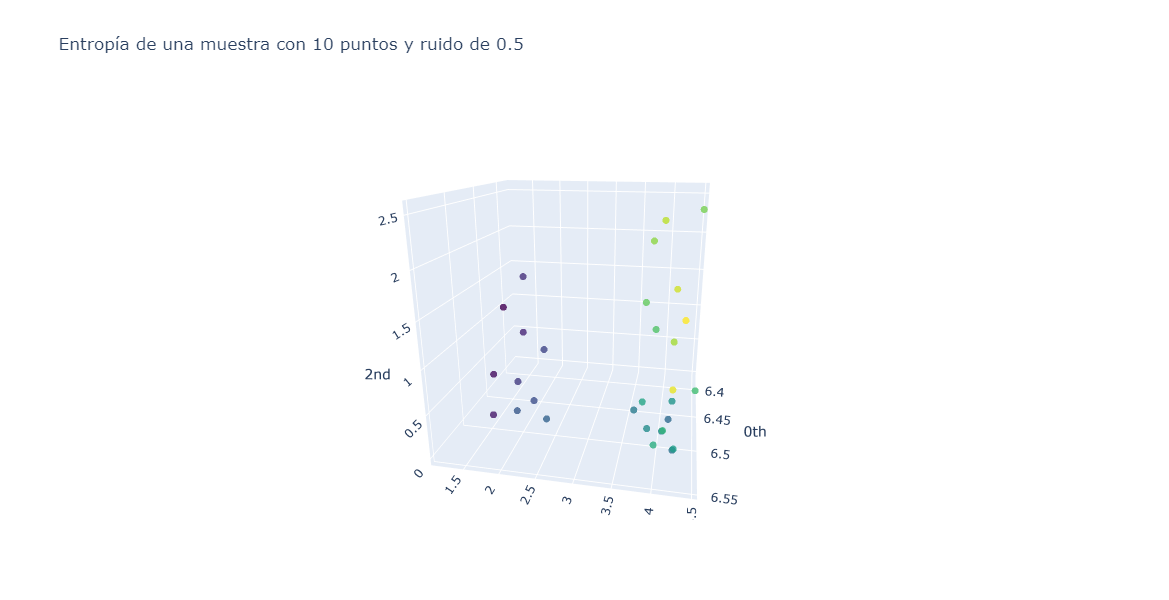

In [104]:
point_clouds_test, labels_test = make_point_clouds(n_samples_per_shape=10, n_points=10, noise=0.5)
pipeline_test = pipeline.fit(point_clouds_test, labels_test)

print(pipeline_test['model'].oob_score_)

diagrams_test = pipeline_test['persistence'].fit_transform(point_clouds_test)
diagrams_entropy_test = pipeline_test['entropy'].fit_transform(diagrams_test)

plot_point_cloud(diagrams_entropy_test, 
                 plotly_params={'layout':{'title':'Entropía de una muestra con 10 puntos y ruido de 0.5', 'width':800, 'height':600}})

## Un ejemplo más realista
El buen desempeño del modelo anterior es de esperarse, pues claramente es fácil clasificar las figuras consideradas. Para contrastar esto, analizaremos un ejemplo más realista, considerando figuras provenientes del mundo real. Al igual que en el ejemplo en que se basa este documento, utilizaremos el conjunto de datos de imágenes 3D utilizado en el [curso](https://www.cs.princeton.edu/courses/archive/fall09/cos429/assignment3.html) de visión por computadora COS 429 de Princeton. Este conjunto de datos consta de 200 modelos organizados en 20 clases de 10 objetos cada uno. Utilizaremos un subconjunto conformado por un humano, un florero, una silla y un biplano. Para acceder al conjunto de datos utilizaremos la función `get_dataset` del módulo `openml.datasets.functions`.

In [118]:
from openml.datasets.functions import get_dataset

df = get_dataset('shapes').get_data(dataset_format='dataframe')[0]
df.head()

x         y         z           target
0  0.341007  0.318606  0.096725  human_arms_out9
1  0.329226  0.421601  0.056749  human_arms_out9
2  0.446869  0.648674  0.124090  human_arms_out9
3  0.314729  0.217860  0.070847  human_arms_out9
4  0.426678  0.919195  0.047609  human_arms_out9

Visualicemos algunas de las muestras.

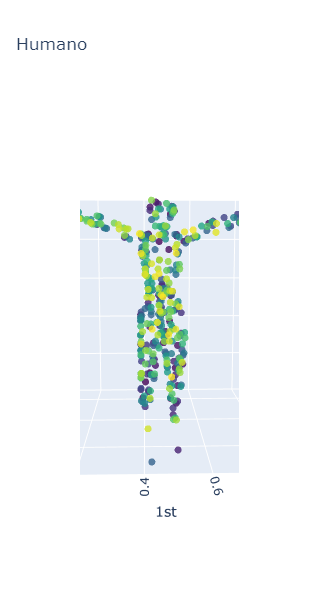

In [155]:
plot_point_cloud(df.query('target == "human_arms_out0"')[['z', 'x', 'y']].values, 
                plotly_params={'layout':{'title':'Humano', 'width':800, 'height':600}})

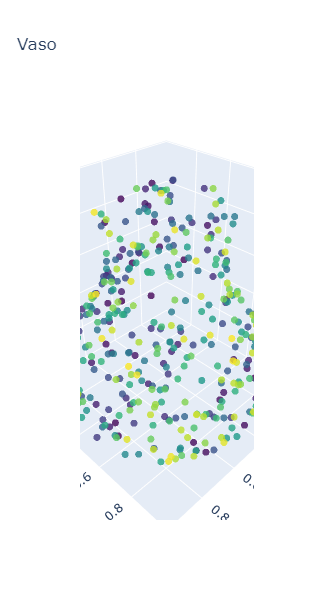

In [153]:
plot_point_cloud(df.query('target == "vase0"')[['z', 'x', 'y']].values, 
                plotly_params={'layout':{'title':'Vaso', 'width':800, 'height':600}})

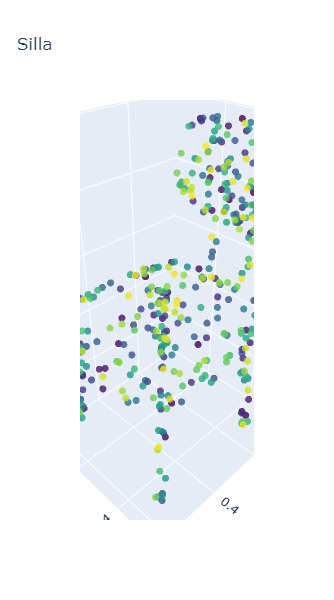

In [151]:
plot_point_cloud(df.query('target == "dining_chair0"')[['z', 'x', 'y']].values, 
                plotly_params={'layout':{'title':'Silla', 'width':800, 'height':600}})

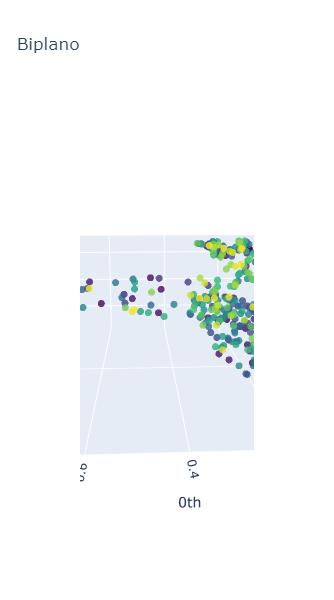

In [149]:
plot_point_cloud(df.query('target == "biplane0"')[['z', 'x', 'y']].values, 
                plotly_params={'layout':{'title':'Biplano', 'width':800, 'height':600}})

Combinemos las distintas nubes de datos en un solo arreglo de NumPy.

In [162]:
import numpy as np

point_clouds_rw = np.asarray(
    [
        df.query('target == @shape')[['x', 'y', 'z']].values
        for shape in df['target'].unique()
    ]
)
point_clouds_rw.shape

(40, 400, 3)

Al igual que en el ejercicio anterior, calculamos los diagramas de persistencia de cada una de las nubes de datos.

In [199]:
%%time
persistence = VietorisRipsPersistence(metric='euclidean',
                                     homology_dimensions=homology_dimensions,
                                     collapse_edges=True)
persistence_diagrams = persistence.fit_transform(point_clouds_rw)

CPU times: total: 4min 32s
Wall time: 4min 34s


Observemos uno de los diagramas de persistencia de cada clase.

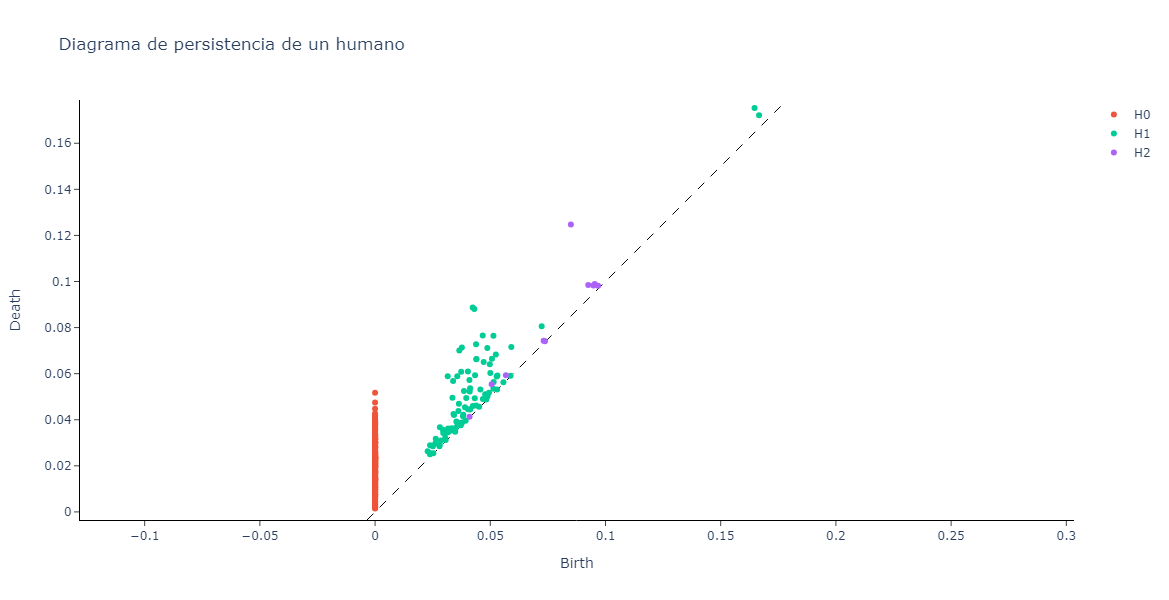

In [202]:
plot_diagram(persistence_diagrams[0], 
             plotly_params={'layout':{'title':'Diagrama de persistencia de un humano', 'width':800, 'height':600}})

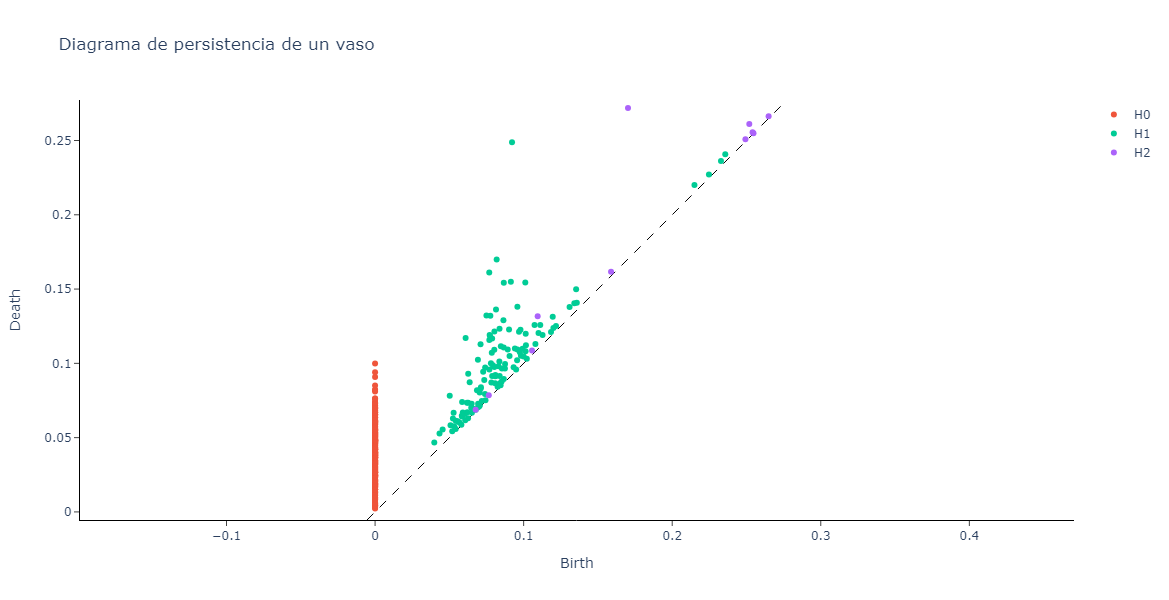

In [203]:
plot_diagram(persistence_diagrams[10], 
             plotly_params={'layout':{'title':'Diagrama de persistencia de un florero', 'width':800, 'height':600}})

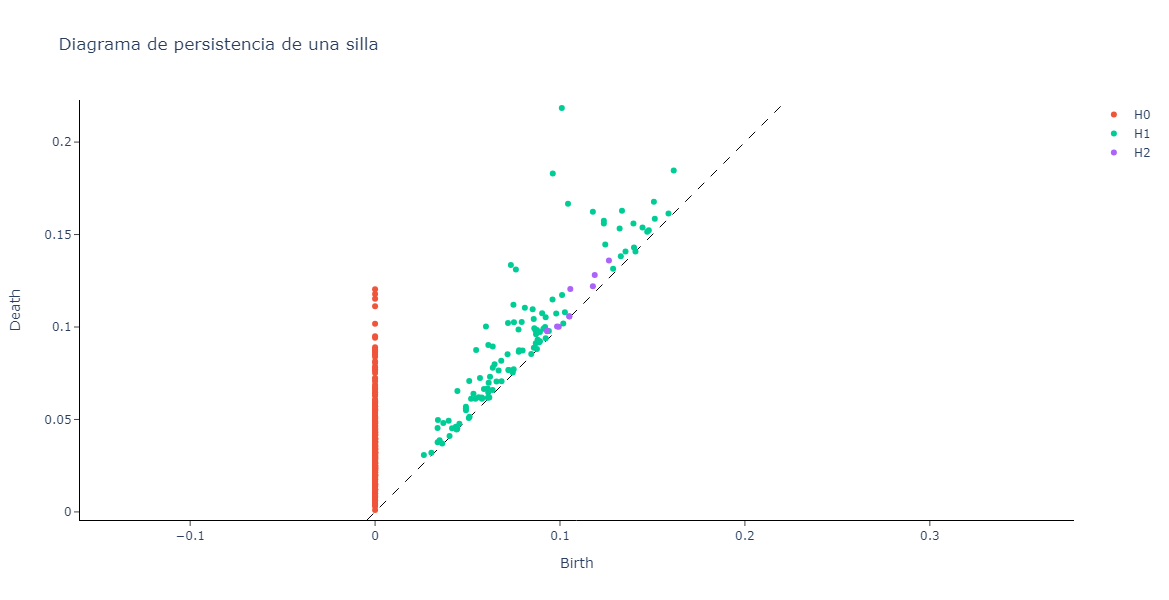

In [204]:
plot_diagram(persistence_diagrams[20], 
             plotly_params={'layout':{'title':'Diagrama de persistencia de una silla', 'width':800, 'height':600}})

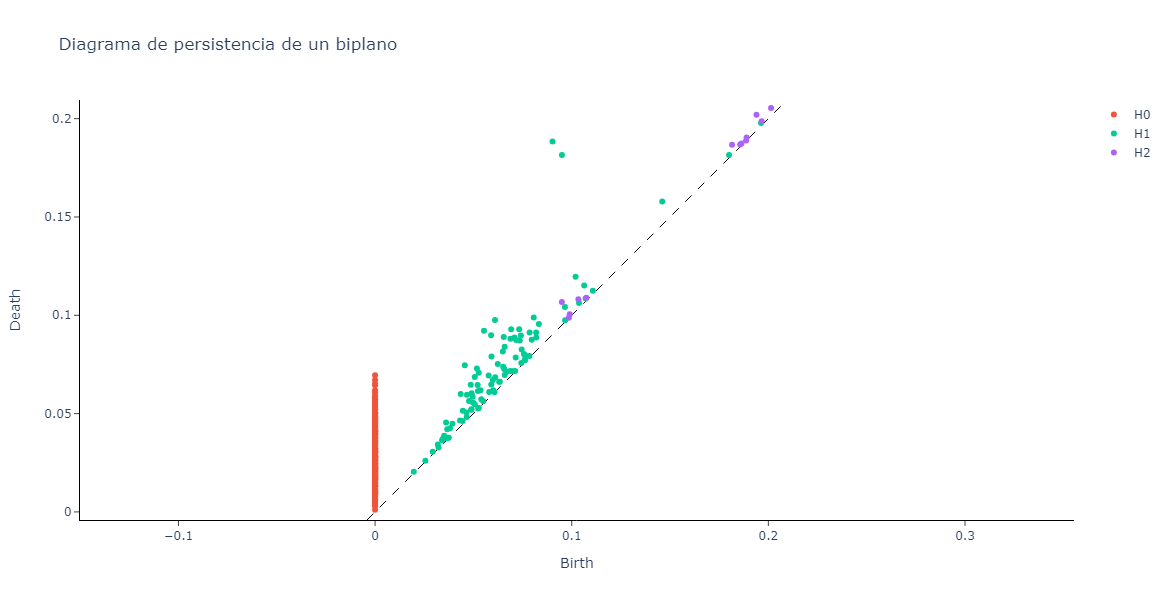

In [205]:
plot_diagram(persistence_diagrams[30], 
             plotly_params={'layout':{'title':'Diagrama de persistencia de un biplano', 'width':800, 'height':600}})

Posteriormente, calculamos la entropía de los diagramas. Podemos observar que, en esta ocasión, no se distinguen grupos de puntos claramente separados. Por lo anterior, se espera un bajo OOB score en el clasificador (Random Forest).

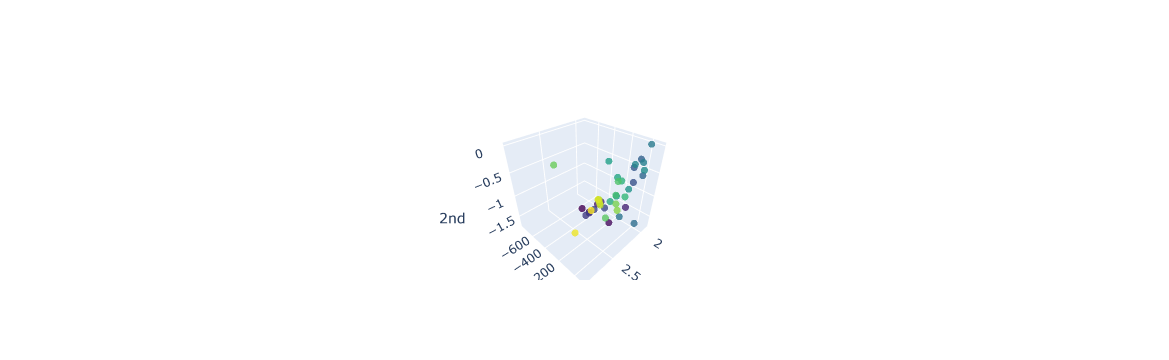

In [213]:
persistence_entropy_rw = PersistenceEntropy(normalize=True)
clusters_rw = persistence_entropy_rw.fit_transform(persistence_diagrams)
plot_point_cloud(clusters_rw)

Antes de entrenar el clasificador, es necesario etiquetar las nubes de datos. El etiquetado que utilizaremos en este ejemplo consiste simplemente en asociar un valor entero a cada nube de puntos según el grupo al que pertenzcan. Una vez realizado el etiquetado, evaluamos el modelo obteniendo un OOB score desfavorable en comparación al obtenido en los ejemplos anteriores.

In [275]:
labels_rw = np.zeros(point_clouds_rw.shape[0])
labels_rw[10:20] = 1
labels_rw[20:30] = 2
labels_rw[30:] = 3

rf = RandomForestClassifier(oob_score=True, random_state=42)
rf.fit(clusters_rw, labels_rw)
rf.oob_score_

0.6

## Mejora del modelo
Anteriormente se mencionó que la entropía es tan solo una de las muchas formas de vectorizar un diagrama de persistencia. Dado que la representación vectorial del diagrama no es única, dicha representación puede llegar a influir en el desempeño del análsis. Para mostrar esto, y buscando una alternativa que ofrezca un mejor OOB score, exploraremos otras formas de vectorizar los diagramas anteriormente calculados.

### Número de puntos
La primer alternativa que exploraremos es la de contar el número de puntos alejados de la diagonal para cada dimensión homológica. Para esto, utilizaremos la función `NumberOfPoints` del módulo `gtda.diagrams`.

In [278]:
from gtda.diagrams import NumberOfPoints

# Modificamos la forma del diagrama para que sea un arreglo 3D
single_diagram = persistence_diagrams[0][None, :, :]
NumberOfPoints().fit_transform(single_diagram)

array([[399,  87,  10]], dtype=int64)

### Amplitudes
Otra característica topológica que podemos extraer del diagrama (menos simple que la anterior), es calcular un vector de *amplitudes* para cada diagrama de persistencia. La idea detrás de esta técnica es particionar el diagram en subdiagramas (uno por cada grupo de homología) y utilizar alguna métrica para calcular la amplitud de cada subdiagrama en comparación al trivial (el que tiene todos sus puntos en la diagonal). El resultado es un vector $v=(v_{q_1},\dots,v_{q_n})$ donde $q_i$ hace referencia al $q$-ésimo grupo de homología. Para realizar el cálculo utilizaremos la función `Amplitude` del módulo `gtda.diagrams`.

In [280]:
from gtda.diagrams import Amplitude

# Utilizaremos la métrica de wasserstein, pero métricas como la bottleneck, landscape, persistence image, etc. también funcionan
Amplitude(metric='wasserstein').fit_transform(single_diagram)

array([[0.22923933, 0.06502641, 0.02047913]])

### Combinación de técnicas
Una vez que resaltamos algunas de las técnicas a partir de las cuales podemos extarer distintas caractrísitcas de los diagramas, un cuestionamiento natural es ¿cuál de todas es la adecuada para este problema?. Sin embargo, no es neceario decidir una única técnica, pues podemos combinar distintas técnicas para extraer tanta información útil de los diagramas como sea conveniente. Para lograr esto utilizaremos la función `make_union` del módulo `sklearn.pipeline`. Además, deado que no conocemos la métrica óptima para encontrar las características topológicas que mejorarán el OOB score, aprovecharemos la función `make_union` para utilizar varias métricas. Las métricas que consideraremos son las siguientes:
* Bottleneck
* Wasserstein
* Landscape
* Persistence image

In [282]:
from sklearn.pipeline import make_union

metrics = [
    {'metric': metric}
    for metric in ['bottleneck', 'wasserstein', 'landscape', 'persistence_image']
]

feature_union = make_union(
    PersistenceEntropy(normalize=True),
    NumberOfPoints(),
    *[Amplitude(**metric) for metric in metrics]
)

Finalmente, al igual que se hizo anteriormente, creamos un Pipeline con la finalidad de simplificar el proceso de ajustar nuestro nuevo modelo.

In [298]:
pipe = Pipeline(
    [
        ('features', feature_union),
        ("rf", RandomForestClassifier(oob_score=True, random_state=42))
    ]
) 
pipe.fit(persistence_diagrams, labels_rw)
pipe['rf'].oob_score_

0.825

Tras el ajuste del nuevo modelo se logró una mejora en el OOB de un 37.5%.